### PCA as a Autoencoder

PCA finds the subspace that either minimizes the reconstuction error or maximizes the projected variance. The optimal subspace are spanned by the priciple components of the empirical covariance matrix. 

PCA is a autoencoder with just one hidden layer, linear activaion(function that encodes and decodes is linear) and MSE loss between the input and reconstruction. It acts as dimensionality reduction that maps n-dimensional to lower. 

In [174]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#Pytorch
from torchvision import datasets, transforms

In [116]:
mnist = fetch_openml('mnist_784', cache=False)
X = mnist["data"].astype('float64')#Data Matrix
y = mnist["target"].astype('int64')

Dataset $D=\left\{x^{(i)} ; i=1: n\right\}$ <br>
where, $x^{(i)} \in R^{28 \times 28}$<br>
Here, $x^{(i)}$ is an mnist image flatten into $784 dim$.<br>

In [127]:
X = X.to_numpy()
y = y.to_numpy()

Shape: (784,)
Label: 5


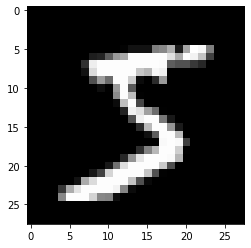

In [132]:
print(f"Shape: {X[0].shape}\nLabel: {y[0]}")
plt.imshow(X[0].reshape(28,28),cmap = "gray");

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Preprocessing

Zero out the mean by subtracting X from mean of X. No need to normalize to unit variance as image is made of pixel whose value range from 0-255


Standarization: $\quad x_{j}^{(i)} \leftarrow \frac{x_{j}^{(i)}-\mu_{j}}{\sigma_{j}} \quad$ where, $j=1: 784$<br>
where, j is column of data Matrix $X$. <br>
$\mu_{j}=\frac{1}{n} \sum_{i=1}^{n} x_{j}^{(i)}$ and $\sigma_{j}^{2}=\frac{1}{n} \sum_{i=1}^{n}\left(x_{j}^{(i)}-\mu_{j}\right)^{2}$<br>
$\mu_{j}$ and $\sigma_{j}^{2}$ are sample mean and variance

In [217]:
X_centered = X_train - np.mean(X_train,axis=0)

For a unit vector u, $x^{T}u$ is the projection of x onto u. So to maximize variance we need to find u that maximizes following:
$$
\begin{aligned}
\frac{1}{n} \sum_{i=1}^{n}\left(x^{(i)^{T}} u\right)^{2} &=\frac{1}{n} \sum_{i=1}^{n} u^{T} x^{(i)} x^{(i)^{T}} u \\
&=u^{T}\left(\frac{1}{n} \sum_{i=1}^{n} x^{(i)} x^{(i)^{T}}\right) u
\end{aligned}
$$
We easily recognize that the maximizing this subject to $\|u\|_{2}=1$(Can be done using Lagrangian....#) gives the principal eigenvector of $\Sigma=\frac{1}{n} \sum_{i=1}^{n} x^{(i)} x^{(i)^{T}}$, which is just the empirical covariance matrix of the data(assumning it has zero mean....##). 



---

#
Set up the lagrangrian,
$$
\mathcal{L}(u, \lambda)=u^{T} \Sigma u-\lambda u^{T} u
$$
where $\lambda$ is called the Lagrange multiplier associated with the equality constraint. It can be established that for $u^{*}$ to be a optimal point to the problem, the gradient of the Lagrangian has to be zero at $u^{*}$ (this is not the only condition, but it is required). That is,
$$
\nabla_{u} \mathcal{L}(u, \lambda)=\nabla_{u}\left(u^{T} \Sigma u-\lambda u^{T} u\right)=2 \Sigma^{T} u-2 \lambda u=0
$$
Notice that this is just the linear equation $\Sigma u=\lambda u$. This shows that the only points which can possibly maximize (or minimize) $u^{T} \Sigma u$ assuming $u^{T} u=1$ are the eigenvectors of $\Sigma$.

---

##
\begin{aligned}
\text{We center the data}: X=X-E[X], \text{so that } E[X]=0
\end{aligned}


\begin{aligned}
\boldsymbol{\Sigma}_{\mathbf{x}} &=\mathrm{E}\left[(\mathrm{X}-\mathrm{E}[\mathrm{X}])(\mathrm{X}-\mathrm{E}[\mathrm{X}])^{\mathrm{T}}\right] \\
&\left.=\mathrm{E}\left[\mathrm{XX}^{\mathrm{T}}\right]-\mathrm{E}[\mathrm{X}] \mathrm{E}[\mathrm{X}]^{\mathrm{T}}\right] \\
&=\mathrm{E}\left[\mathbf{X} \mathbf{X}^{\mathrm{T}}\right]
\end{aligned}

In [142]:
cov_X =  X_centered.T.dot(X_centered)/(X_train.shape[0]-1)

In [144]:
eigenvalues, eigenvectors = eig(cov_X)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

In [149]:
sortIndex = np.flip(np.argsort(eigenvalues))

In [152]:
sortIndex.shape

(784,)

In [156]:
def getKeigVec(npArr,sortIndex):
    return npArr[:,sortIndex]

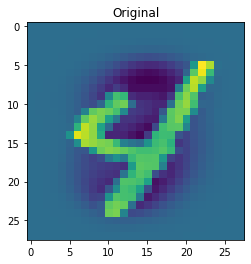

In [169]:
plt.title("Original")
plt.imshow(X_centered[0].reshape(28,28));

We choose top k eigen vectors from u, which becomes the orthogonal basis of the data. Then use that basis to represent the data. When k < 784, we would sucessfully reduce dimension or encode into low dimentional and can attempt to reconstruct or decode back to original image with a reconstructional error.

$y^{(i)}=\left[\begin{array}{c}u_{1}^{T} x^{(i)} \\ u_{2}^{T} x^{(i)} \\ \vdots \\ u_{k}^{T} x^{(i)}\end{array}\right] \in \mathbb{R}^{k}$<br>
<br>
Now, $y^{(i)} \in \mathbb{R}^{k}$

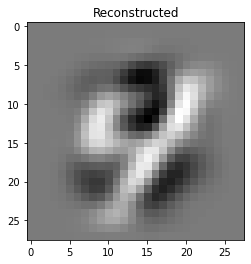


Overall Reconstruction Error ( k = 16): 1769.9475489447036


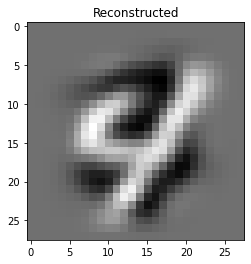


Overall Reconstruction Error ( k = 30): 1173.1384804826835


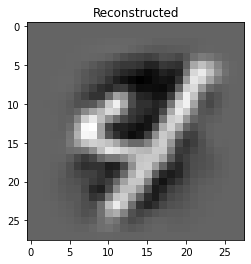


Overall Reconstruction Error ( k = 100): 371.5883695931411


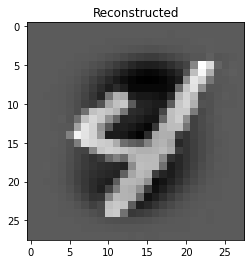


Overall Reconstruction Error ( k = 500): 3.233233202045992


In [215]:
for k in [16,30,100,500]:
    kComp = getKeigVec(eigenvectors,sortIndex[:k])
    X_projected_k = X_centered.dot(kComp)
    X_reconstructed_k = X_projected_k.dot(kComp.T)
    plt.figure()
    plt.title("Reconstructed")
    plt.imshow(X_reconstructed_k[0].reshape(28,28))
    plt.show()
    reconstruction_error = mean_squared_error(X_centered, X_reconstructed_k)
    print(f"\nOverall Reconstruction Error ( k = {k}): { reconstruction_error}")
    print('='*50)

In [189]:
pca = PCA(n_components=16)
pca.fit(X)

PCA(n_components=16)

Overall Reconstruction Error: 1770.4597332879594


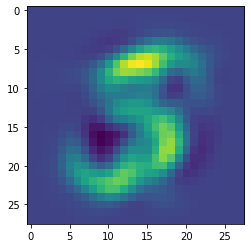

In [196]:
X_projected_sklearn = pca.transform(X)
X_reconstructed_sklearn = pca.inverse_transform(X_projected_sklearn)
reconstruction_error = mean_squared_error(X, X_reconstructed_sklearn)
print(f"Overall Reconstruction Error: {reconstruction_error}")
plt.imshow(X_reconstructed_sklearn[0].reshape(28,28));

In [212]:
done = []
reconstructions = {}
original_images = {}
for i in range(1000):
    image,label = X[i],y[i]
    if label not in done:
        done.append(label)
        original_images[done[-1]] = image.reshape(28,28)
        reconstructions[done[-1]] = X_reconstructed_sklearn[i].reshape(28,28) 

    if len(done) == 10:
        break
                


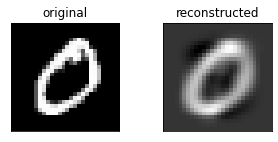

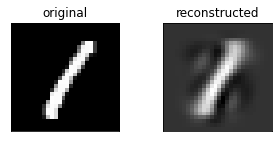

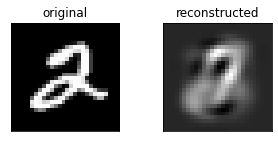

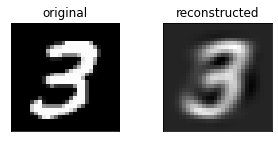

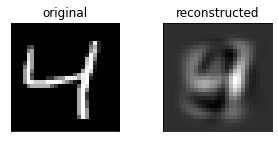

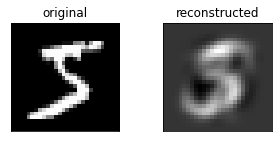

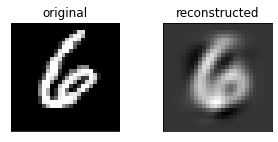

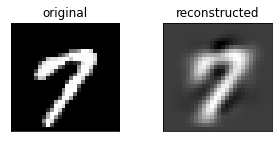

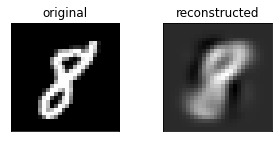

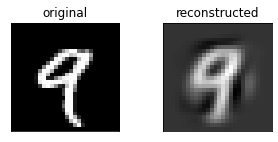

In [213]:
#Plotting the figures
for i in range(10):
    plt.figure(figsize=(5, 2))
    
    ax = plt.subplot(1, 2, 1)
    plt.imshow(original_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('original')
    
    ax = plt.subplot(1, 2, 2)
    plt.imshow(reconstructions[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('reconstructed')